# Models

## Imports

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [2]:
# Operations on the GPU if available
if torch.cuda.is_available():
    print("The code is running on GPU.")
else:
    print("The code is running on CPU.")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code is running on CPU.


In [3]:
%load_ext line_profiler

## Functions

In [4]:
class Dataset(data.Dataset):
    """Creates a Dataset depending on the given matrices.
    
    Attributes:
        inputs(np.ndarray): Sliced matrix of inputs.
        p_type(np.ndarray): Sliced matrix of point type (from inputs).
        targets(np.ndarray): Sliced matrix of targets.
        n_u(int): Number of data points.
        n_f(int): Number of collocation points.
    
    Returns:
        X(np.ndarray): Input observation at idx.
        y(np.ndarray): Target observation at idx.
        p_type(np.ndarray): Point type at idx
    """
    def __init__(self, X_u, X_f, y, data_params, collocation=True, train=True, split=0.95):
        """Inits the Dataset, depends on collocation flag.
        
        Args:
        inputs(np.ndarray): Matrix of inputs.
        targets(np.ndarray): Matrix of targets.
        data_params(Dict): Includes the parameters of the dataset.
        collocation(bool): Indicates if the matrices should be sliced _
            to only include data points or also collocation points.
        """
        
        # Unpack parameters
        self.n_u = data_params['n_data']
        self.n_f = data_params['n_collocation']
        self.seed = data_params['seed']
        
        X_train, X_test, y_train, y_test = train_test_split(X_u, y,
                                                            train_size=split,
                                                            random_state=self.seed)
        
        idx = np.random.choice(X_train.shape[0], self.n_u, replace=False)
        X_u_train = X_train[idx, 0:2]
        p_train = X_train[idx, -1].reshape((-1,1))
        y_train = y_train[idx, :]
        
        if collocation:
            idx = np.random.choice(X_f.shape[0], self.n_f, replace=False)
            X_train = np.vstack((X_u_train, X_f[idx, 0:2]))
            p_train = np.vstack((p_train, X_f[idx, -1].reshape((-1,1))))
            y_train = np.vstack((y_train, np.zeros((self.n_f, 1))))
        else:
            X_train = X_u_train
        
        if train:
            self.inputs = X_train
            self.p_type = p_train
            self.targets = y_train
        else:
            self.inputs = X_test[:, 0:2]
            self.p_type = X_test[:, -1].reshape((-1,1))
            self.targets = y_test

    def __len__(self):
        """Returns the size of the dataset."""
        return len(self.targets)

    def __getitem__(self, idx):
        """Retrieve inputs and targets at the given index."""
        X = torch.Tensor(self.inputs[idx])
        p_type = torch.Tensor(self.p_type[idx])
        y = torch.Tensor(self.targets[idx])

        return X, p_type, y

In [5]:
def get_activation(name):
    """Matches the activation function name with the actual Pytorch function.

    Args:
        name(str): Name of the activation function.

    Returns:
        act(fun): Pytorch activation function.
    """

    activations = {'tanh': nn.Tanh(),
                   'relu': nn.ReLU(inplace=True),
                   'leakyrelu': nn.LeakyReLU(inplace=True),
                   'sigmoid': nn.Sigmoid()
                  }

    if name.lower() in activations:
        return activations[name.lower()]
    else: 
        raise ValueError(f'Activation function "{name}" not implemented, available activations are {list(activations.keys())}.')

def get_loss(name):
    """Matches the loss function name with the actual Pytorch function.

    Args:
        name(str): Name of the loss function.

    Returns:
        loss(fun): Pytorch losss function.
    """

    loss_funs = {'MSE': nn.MSELoss(),
                 'MAE': nn.L1Loss(),
                }

    if name in loss_funs:
        return loss_funs[name]
    else: 
        raise ValueError(f'Loss function "{name}" not implemented, available loss functions are {list(loss_funs.keys())}.')

In [6]:
class NN(nn.Module):
    """Feed-Forward Neural Network (NN).

    Attributes:
        layers(list): Architecture of the NN.
        act_name(str): Activation function to use after each layer.
        depth(int): Maximum depth of the NN.
        nn(nn.Sequential): Sequential container of the NN.
    """
    
    def __init__(self, nn_params):
        """Inits the NN architecture with given parameters."""
        super().__init__()
        
        # Unpack parameters
        self.layers = nn_params['layers']
        #self.activation = nn_params['activation']
        #self.loss_fun = nn_params['loss_function']
        
        # Define parameters
        self.depth = len(layers) - 1
        
        # Create architecture
        self.nn = nn.Sequential()
        
        # Add layers until output layer
        for n in range(self.depth - 1):
            self.nn.add_module(f"layer_{n}", nn.Linear(layers[n], layers[n + 1]))
            self.nn.add_module(f"act_{n}", nn.Tanh())
        
        # Output layer (excluding activation)
        self.nn.add_module(f"layer_{n + 1}", nn.Linear(layers[n + 1], layers[n + 2]))
        
        # Weight initialization (already Kaiming uniform)
#         for m in self.modules():
#             if isinstance(m, nn.Linear):
#                 nn.init.xavier_normal_(m.weight)
#                 nn.init.constant_(m.bias, 0)

    def forward_nn(self, x):
        """Feed-forward the inputs through the network."""
        return self.nn(x)
    
    def loss_nn(self, y_hat, y):
        loss = nn.MSELoss()
        return loss(y_hat, y)

In [7]:
class PINN(NN):
    """Physics-Informed Neural Network (NN).

    Attributes:
        layers(list): Architecture of the NN.
        act_name(str): Activation function to use after each layer.
        depth(int): Maximum depth of the NN.
        nn(nn.Sequential): Sequential container of the NN.
    """
    def __init__(self, nn_params, data_params):
        super().__init__(nn_params)
        
        # Unpack equation parameters
        self.m = torch.Tensor([data_params['inertia']])
        self.d = torch.Tensor([data_params['damping']])
        self.B = torch.Tensor([data_params['susceptance']])

    def forward_pinn(self, x):
        
        x.requires_grad_(True)
        
        # Forward pass
        u = self.forward_nn(x)
        
        # First derivative
        dudx = self.gradients(u, x)
        dudt = dudx[:, 1]
        
        # Second derivative
        dudxx = self.gradients(dudx, x)
        dudtt = dudxx[:, 1]
        
        #u.detach_()

        # Physics term
        f = self.m * dudtt + self.d * dudt + self.B * torch.sin(u) - x[:, 0]
        #print(dudx)
        #print(dudt)
        #print(dudxx)
        #print(dudtt)
        return u, f
    
    def loss_pinn(self, u_hat, u, p_type, f, w1=1, w2=1):

        # Angle loss
        #print("u:", u)
        u_filtered = u_hat * p_type
        #print("u_filtered:",u_filtered)
        MSE_u = self.loss_nn(u_filtered, u)
        #print("MSE_u:", MSE_u)

        # Physics loss
        MSE_f = torch.mean(f**2)
        #print("MSE_f:", MSE_f)

        # Total loss
        MSE = w1*MSE_u + w2*MSE_f
        
        return MSE_u, MSE_f, MSE

    def gradients(self, outputs, inputs):
        return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs, requires_grad=False), only_inputs=True, retain_graph=True, create_graph=True)[0]

In [24]:
def train_NN(model, train_loader, test_loader, nn_params, data_params):
    
    optim = nn_params['optim']
    
    # Initialize the optimizer
    if optim == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    elif optim == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # Output dictionary
    out_dict = {'train_loss': [],
                'test_loss': []
               }
    
    train_loss = []
    
    for epoch in tqdm(range(n_epochs), unit='epoch'):
        
        # Activate train mode
        model.train()
        
        for (X_train, p_type, Y_train) in train_loader:
            
            X_train, p_type, Y_train = X_train.to(device), p_type.to(device), Y_train.to(device)
            
            # Zero the gradients computed for each weight
            optimizer.zero_grad()
            
            # Forward pass
            Y_hat = model.forward_nn(X_train)

            # Compute the loss
            loss = model.loss_nn(Y_hat, Y_train)

            # Backward pass through the network
            loss.backward()

            # Update the weights
            optimizer.step()
            
            # Save train loss
            train_loss.append(loss.data.numpy())

        if epoch % 500 == 0:

            # Activate evaluation mode
            model.eval()

            test_loss = []

            for (X_test, p_type, Y_test) in test_loader:

                X_test, p_type, Y_test = X_test.to(device), p_type.to(device), Y_test.to(device)

                with torch.no_grad():

                    Y_hat = model.forward_nn(X_test)

                    test_loss.append(model.loss_nn(Y_hat, Y_test).cpu().item())

            out_dict['test_loss'].append(np.mean(test_loss))
        
        # Pack epoch losses
        out_dict['train_loss'].append(np.mean(train_loss))
        
    return out_dict

In [9]:
def train_PINN(model, train_loader, test_loader, nn_params, data_params):
    
    optim = nn_params['optim']
    
    # Initialize the optimizer
    if optim == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    elif optim == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        
    n_data = data_params['n_data']
    n_collocation = data_params['n_collocation']
    w2 = n_data/(n_data+n_collocation)
    
    # Output dictionary
    out_dict = {'train_loss': [],
                'test_loss': [],
                'MSE_u': [],
                'MSE_f': []
               }
    
    train_loss = []
    loss_u_e = []
    loss_f_e = []
    
    for epoch in tqdm(range(n_epochs), unit='epoch'):
        
        # Activate train mode
        model.train()
        
        for (X_train, p_type, Y_train) in train_loader:
            
            X_train, p_type, Y_train = X_train.to(device), p_type.to(device), Y_train.to(device)
            
            # Zero the gradients computed for each weight
            optimizer.zero_grad()
            
            # Forward pass
            u, f = model.forward_pinn(X_train)

            # Compute the loss
            loss_u, loss_f, loss = model.loss_pinn(u, Y_train, p_type, f, w2)
            
            # Backward pass through the network
            loss.backward(retain_graph=True)

            # Update the weights
            optimizer.step()
        
            # Save losses
            loss_u_e.append(loss_u.data.numpy())
            loss_f_e.append(loss_f.data.numpy())
            train_loss.append(loss.data.numpy())
        
        if epoch % 1000 == 0:
            
            # Activate evaluation mode
            model.eval()

            test_loss = []

            for (X_test, p_type, Y_test) in test_loader:

                X_test, p_type, Y_test = X_test.to(device), p_type.to(device), Y_test.to(device)
                
                with torch.no_grad():

                    u = model.forward_nn(X_test)
                
                    test_loss.append(model.loss_nn(u, Y_test).cpu().item())
            
            out_dict['test_loss'].append(np.mean(test_loss))
        
        # Pack epoch losses
        out_dict['train_loss'].append(np.mean(train_loss))
        out_dict['MSE_u'].append(np.mean(loss_u_e))
        out_dict['MSE_f'].append(np.mean(loss_f_e))
        
    return out_dict

In [10]:
def plot_loss(results):
    plt.plot(results['train_loss'], label='train')
    plt.plot(results['test_loss'], label='test')
    plt.yscale('log')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

## Parameters

In [11]:
# Data parameters
n_data = 101 # number of data points
n_collocation = 8000 # number of collocation points

m = 0.15 # angular inertia
d = 0.15 # damping coefficient
B = 0.2 # susceptance [pu]
delta_0 = 0 # initial angle [rad]
omega_0 = 0 # initial angular speed [rad/s]

p_min = 0.08 # minimum power [pu]
p_max = 0.18 # maximum power [pu]
p_span = (p_min, p_max)

t_min = 0 # [seconds]
t_max = 10 # [seconds]
t_span = (t_min, t_max)

seed = 123

data_params = {'n_data': n_data,
               'n_collocation': n_collocation,
               'inertia': m,
               'damping': d,
               'susceptance': B,
               'delta_0': delta_0,
               'omega_0': omega_0,
               'p_span': p_span,
               't_span': t_span,
               'seed': seed
              }

In [12]:
# NN parameters
lr = 0.001
n_epochs = 10000
batch_size = 500
optim = 'Adam' # SGD, LFBGS
loss = 'MSE' # MAE
activation = 'tanh'
layers = [2, 20, 20, 1] # NN architecture

nn_params = {'learning_rate': lr,
             'n_epochs': n_epochs,
             'optim': optim,
             'loss_function': get_loss(loss),
             'activation': get_activation(activation),
             'layers': layers
            }

## Data

In [13]:
with np.load('../data/data.npz') as data_npz:
    X_u = data_npz['X_u']
    X_f = data_npz['X_f']
    y_delta = data_npz['y_delta']
    y_omega = data_npz['y_omega']

In [14]:
print(f"Input shape: {X_u.shape}\n"
      f"Input shape: {X_f.shape}\n"
      f"Output shape: {y_delta.shape}\n"
      f"Output shape: {y_omega.shape}")

Input shape: (10201, 3)
Input shape: (8000, 3)
Output shape: (10201, 1)
Output shape: (10201, 1)


In [15]:
# Create datasets
train_short = Dataset(X_u, X_f, y_delta, data_params, collocation=False)
train_long = Dataset(X_u, X_f, y_delta, data_params)
test = Dataset(X_u, X_f, y_delta, data_params, train=False)

# Create train and test loaders
train_loader_short = data.DataLoader(train_short, batch_size=batch_size, shuffle=True)
train_loader_long = data.DataLoader(train_long, batch_size=batch_size, shuffle=True)
test_loader = data.DataLoader(test, batch_size=batch_size, shuffle=False) # num_workers=1

In [16]:
train_short.inputs.shape

(101, 2)

In [17]:
train_long.inputs.shape

(8101, 2)

In [18]:
test.inputs.shape

(511, 2)

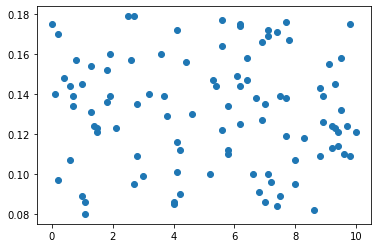

In [19]:
plt.scatter(train_short.inputs[:,1], train_short.inputs[:,0])

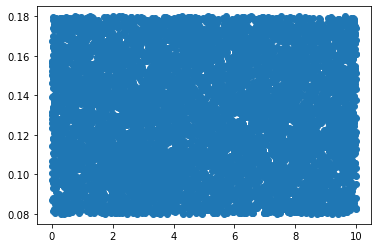

In [20]:
plt.scatter(train_long.inputs[:,1], train_long.inputs[:,0])

## NN

In [21]:
# Initialize model
model_NN = NN(nn_params)

# To GPU or CPU
model_NN.to(device)

NN(
  (nn): Sequential(
    (layer_0): Linear(in_features=2, out_features=20, bias=True)
    (act_0): Tanh()
    (layer_1): Linear(in_features=20, out_features=20, bias=True)
    (act_1): Tanh()
    (layer_2): Linear(in_features=20, out_features=1, bias=True)
  )
)

In [22]:
#%lprun -f train_NN train_NN(model_NN, train_loader_short, test_loader, nn_params, data_params)

In [25]:
# Train
results_NNshort = train_NN(model_NN, train_loader_short, test_loader, nn_params, data_params)

100%|██████████| 10000/10000 [01:45<00:00, 95.06epoch/s]


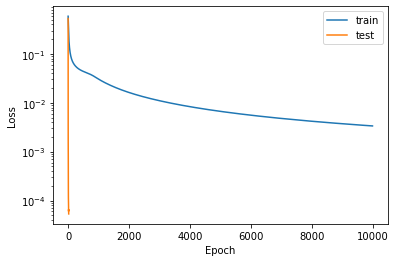

In [26]:
plot_loss(results_NNshort)

In [31]:
def plot_prediction(model, idx=20):
    preds = []
    for x in X_u[idx*n_data:idx*n_data+n_data, 0:2]:
        x = torch.Tensor(x)
        preds.append(model.forward_nn(x).item())

    plt.plot(X_u[idx*n_data:idx*n_data+n_data, 1], y_delta[idx*n_data:idx*n_data+n_data], label="exact")
    plt.plot(X_u[idx*n_data:idx*n_data+n_data, 1], preds, label="prediction")
    plt.xlabel("Time [s]")
    plt.ylabel("δ [rad]")
    plt.legend()

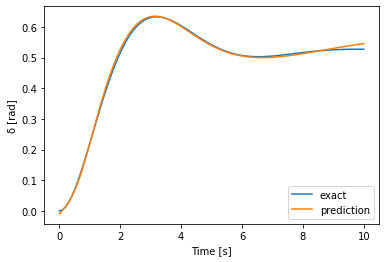

In [32]:
plot_prediction(model_NN)

## PINN

In [33]:
# Initialize model
model_PINN = PINN(nn_params, data_params)

# To GPU or CPU
model_PINN.to(device)

PINN(
  (nn): Sequential(
    (layer_0): Linear(in_features=2, out_features=20, bias=True)
    (act_0): Tanh()
    (layer_1): Linear(in_features=20, out_features=20, bias=True)
    (act_1): Tanh()
    (layer_2): Linear(in_features=20, out_features=1, bias=True)
  )
)

In [22]:
results_PINNlong = train_PINN(model_PINN, train_loader_long, test_loader, nn_params, data_params)

100%|██████████| 10000/10000 [2:02:08<00:00,  1.36epoch/s] 


In [69]:
%lprun -f train_PINN train_PINN(model_PINN, train_loader_long, test_loader, nn_params, data_params)

100%|██████████| 5/5 [00:03<00:00,  1.51epoch/s]


Timer unit: 1e-06 s

Total time: 3.31679 s
File: <ipython-input-63-205e5a854b1b>
Function: train_PINN at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def train_PINN(model, train_loader, test_loader, nn_params, data_params):
     2                                               
     3         1          3.0      3.0      0.0      optim = nn_params['optim']
     4                                               
     5                                               # Initialize the optimizer
     6         1          3.0      3.0      0.0      if optim == 'SGD':
     7                                                   optimizer = torch.optim.SGD(model.parameters(), lr=lr)
     8         1          1.0      1.0      0.0      elif optim == 'Adam':
     9         1        317.0    317.0      0.0          optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    10                                                   
   

In [58]:
%lprun -f model_PINN.forward_pinn model_PINN.forward_pinn(next(iter(train_loader_long))[0])

Timer unit: 1e-06 s

Total time: 0.003945 s
File: <ipython-input-30-b1b3c39066c7>
Function: forward_pinn at line 18

Line #      Hits         Time  Per Hit   % Time  Line Contents
    18                                               def forward_pinn(self, x):
    19                                                   
    20         1         16.0     16.0      0.4          x.requires_grad_(True)
    21                                                   
    22                                                   # Forward pass
    23         1       1262.0   1262.0     32.0          u = self.forward_nn(x)
    24                                                   
    25                                                   # First derivative
    26         1        862.0    862.0     21.9          dudx = self.gradients(u, x)
    27         1         55.0     55.0      1.4          dudt = dudx[:, 1]
    28                                                   
    29                                  

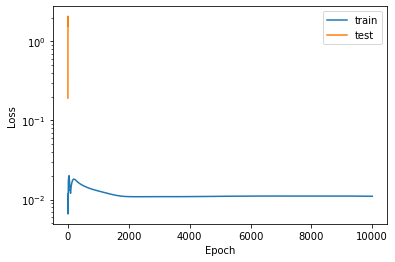

In [23]:
plot_loss(results_PINNlong)

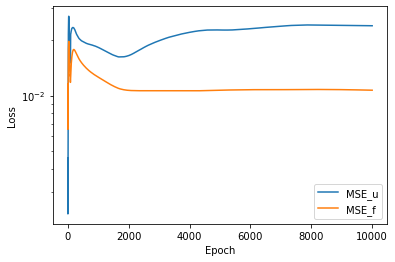

In [24]:
plt.plot(results_PINNlong['MSE_u'], label='MSE_u')
plt.plot(results_PINNlong['MSE_f'], label='MSE_f')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

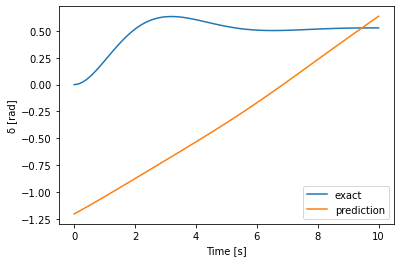

In [27]:
plot_prediction(model_PINN)

## BPINN

### Bayes rule

Likelihood: $$p(D|\theta)$$
Prior: $$p(\theta)$$
Posterior: $$p(\theta|D) = \frac{p(D|\theta)p(\theta)}{p(D)} = \frac{p(D|\theta)p(\theta)}{\sum p(D|\theta)p(\theta)d\theta}$$
MCMC: $$p(y^*|D) = \mathbb{E}_{p(\theta|D)}p(y^*|\theta) \approx \frac{1}{K} \sum_{k=1}^{K} p(y^*|\theta^k)$$
VI: $$q(z)$$
$$\mathbb{KL}(q(z)||p(y|x)) = \mathbb{E}_q\left[log\frac{q(z)}{p(y|x)}\right]$$
Aleatoric (data) and Epistemic (knowledge or model) Uncertainty

In [21]:
from torchvision import datasets, transforms

In [22]:
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
from pyro.infer import SVI, Trace_ELBO, MCMC, NUTS, HMC
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.optim import Adam
from pyro.infer import Predictive
import seaborn as sns

In [23]:
from matplotlib import colors

In [24]:
class Model(PyroModule):
    def __init__(self, h0=2, h1=20, h2=20, sigma=1):
        super().__init__()
        self.fc1 = PyroModule[nn.Linear](h0, h1)
        self.fc1.weight = PyroSample(dist.Normal(0., sigma).expand([h1, h0]).to_event(2))
        self.fc1.bias = PyroSample(dist.Normal(0., sigma).expand([h1]).to_event(1))
        self.fc2 = PyroModule[nn.Linear](h1, h2)
        self.fc2.weight = PyroSample(dist.Normal(0., sigma).expand([h2, h1]).to_event(2))
        self.fc2.bias = PyroSample(dist.Normal(0., sigma).expand([h2]).to_event(1))
        self.fc3 = PyroModule[nn.Linear](h2, 1)
        self.fc3.weight = PyroSample(dist.Normal(0., sigma).expand([1, h2]).to_event(2))
        self.fc3.bias = PyroSample(dist.Normal(0., sigma).expand([1]).to_event(1))
        self.act = nn.Tanh()

    def forward(self, x, y=None):
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        mu = self.fc3(x).squeeze()
        sigma = 0.001 # change noise or noise-less
        with pyro.plate("data", x.shape[0]):
            y = pyro.sample("obs", dist.Normal(mu, sigma), obs=y)
        return y

In [25]:
# Prepare training data
idx=0
# X = torch.tensor(X_u[idx*n_data:idx*n_data+n_data,0:2]).float()
# y = torch.tensor(y_delta[idx*n_data:idx*n_data+n_data,0]).float()
X = torch.tensor(X_u[:,0:2]).float()
y = torch.tensor(y_delta[:,0]).float()

# Prepare test data for Pyro
X_test = torch.tensor(test.inputs).float()
y_test = torch.tensor(test.targets).float()

# Numpyro - HMC/NUTS

In [67]:
from jax import vmap
import jax.numpy as jnp
import jax.random as random
from jax.config import config
config.update("jax_enable_x64", True)

import os
import time
import numpyro
from numpyro import handlers
import numpyro.distributions as dist
from numpyro.infer import MCMC, HMC, NUTS

In [68]:
idx = 0
# X = jnp.array(X_u[:,0:2])
# y = jnp.array(y_delta[:,0])
X = jnp.array(X_u[idx*n_data:idx*n_data+n_data,0:2])
y = jnp.array(y_delta[idx*n_data:idx*n_data+n_data,0])

# Prepare test data for Pyro
X_test = jnp.array(test.inputs)
y_test = jnp.array(test.targets)

In [69]:
# activation function used in the nn
def nonlin(x):
    return jnp.tanh(x)

# a two-layer bayesian neural network with computational flow
# given by D_X => D_H => D_H => D_Y where D_H is the number of
# hidden units. (note we indicate tensor dimensions in the comments)
def model_bnn(X, Y, D_H, sigma_obs=0.001):

    D_X, D_Y = X.shape[1], 1

    # sample first layer (we put unit normal priors on all weights)
    w1 = numpyro.sample("w1", dist.Normal(jnp.zeros((D_X, D_H)), jnp.ones((D_X, D_H))))  # D_X D_H
    z1 = nonlin(jnp.matmul(X, w1))   # N D_H  <= first layer of activations

    # sample second layer
    w2 = numpyro.sample("w2", dist.Normal(jnp.zeros((D_H, D_H)), jnp.ones((D_H, D_H))))  # D_H D_H
    z2 = nonlin(jnp.matmul(z1, w2))  # N D_H  <= second layer of activations

    # sample final layer of weights and neural network output
    w3 = numpyro.sample("w3", dist.Normal(jnp.zeros((D_H, D_Y)), jnp.ones((D_H, D_Y))))  # D_H D_Y
    z3 = jnp.matmul(z2, w3)  # N D_Y  <= output of the neural network

    # observe data
    numpyro.sample("Y", dist.Normal(z3, sigma_obs), obs=Y)

In [70]:
# helper function for HMC inference
def run_inference(model, args, rng_key, X, Y, D_H):
    start = time.time()
    kernel = NUTS(model)
    mcmc = MCMC(kernel, args['num_warmup'], args['num_samples'], num_chains=args['num_chains'],
                progress_bar=False if "NUMPYRO_SPHINXBUILD" in os.environ else True)
    mcmc.run(rng_key, X, Y, D_H)
    mcmc.print_summary()
    print('\nMCMC elapsed time:', time.time() - start)
    return mcmc.get_samples()


# helper function for prediction
def predict(model, rng_key, samples, X, D_H):
    model = handlers.substitute(handlers.seed(model, rng_key), samples)
    # note that Y will be sampled in the model because we pass Y=None here
    model_trace = handlers.trace(model).get_trace(X=X, Y=None, D_H=D_H)
    return model_trace['Y']['value']

In [71]:
D_H = 20
args = {'num_samples': 10000,
       'num_warmup': 1000,
       'num_chains': 1}
# do inference
rng_key, rng_key_predict = random.split(random.PRNGKey(0))
samples = run_inference(model_bnn, args, rng_key, X, y, D_H)

sample: 100%|██████████| 11000/11000 [48:50<00:00,  3.75it/s, 1023 steps of size 5.41e-09. acc. prob=0.73]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   w1[0,0]     -0.88      0.00     -0.88     -0.88     -0.88      0.50      1.00
   w1[0,1]      0.77      0.00      0.77      0.77      0.77      0.50      1.00
   w1[0,2]      1.90      0.00      1.90      1.90      1.90      0.50      1.00
   w1[0,3]     -0.18      0.00     -0.18     -0.18     -0.18      0.50      1.00
   w1[0,4]      1.69      0.00      1.69      1.69      1.69      0.50      1.00
   w1[0,5]     -0.39      0.00     -0.39     -0.39     -0.39      0.50      1.00
   w1[0,6]      0.61      0.00      0.61      0.61      0.61      0.50      1.00
   w1[0,7]     -1.19      0.00     -1.19     -1.19     -1.19      0.50      1.00
   w1[0,8]     -1.79      0.00     -1.79     -1.79     -1.79      0.50      1.00
   w1[0,9]      0.64      0.00      0.64      0.64      0.64      0.50      1.00
  w1[0,10]     -1.62      0.00     -1.62     -1.62     -1.62      0.50      1.00
  w1[0,11]      1.06      0

In [73]:
# predict Y_test at inputs X_test
vmap_args = (samples, random.split(rng_key_predict, args['num_samples'] * args['num_chains']))
predictions = vmap(lambda samples, rng_key: predict(model_bnn, rng_key, samples, X, D_H))(*vmap_args)

In [78]:
predictions = predictions[..., 0]

In [79]:
# compute mean prediction and confidence interval around median
mean_prediction = jnp.mean(predictions, axis=0)
percentiles = np.percentile(predictions, [5.0, 95.0], axis=0)

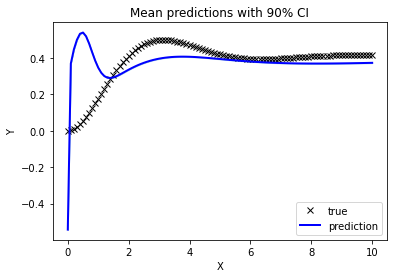

In [85]:
# make plots
fig, ax = plt.subplots(1, 1)

# plot training data
ax.plot(X[:, 1], y, 'kx', label='true')
# plot 90% confidence level of predictions
ax.fill_between(X[:, 1], percentiles[0, :], percentiles[1, :], color='lightblue')
# plot mean prediction
ax.plot(X[:, 1], mean_prediction, 'blue', ls='solid', lw=2.0, label='prediction')
ax.set(xlabel="X", ylabel="Y", title="Mean predictions with 90% CI")
ax.legend()

In [ ]:
plt.savefig('bnn_plot.pdf')
plt.tight_layout()

## HMC/NUTS

In [62]:
# Run inference in Pyro
model = Model()
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=500, warmup_steps=100, num_chains=1)
mcmc.run(X, y)

# Show summary of inference results
mcmc.summary()

Sample:  26%|██▌       | 155/600 [17:54, 11.24s/it, step size=1.61e-04, acc. prob=0.972]

KeyboardInterrupt: 

In [26]:
# Extract samples from posterior
posterior_samples = mcmc.get_samples()
print(posterior_samples.keys())

NameError: name 'mcmc' is not defined

In [109]:
posterior_samples["bayesian_model$$$nn.layer_0.bias"].shape

torch.Size([100, 20])

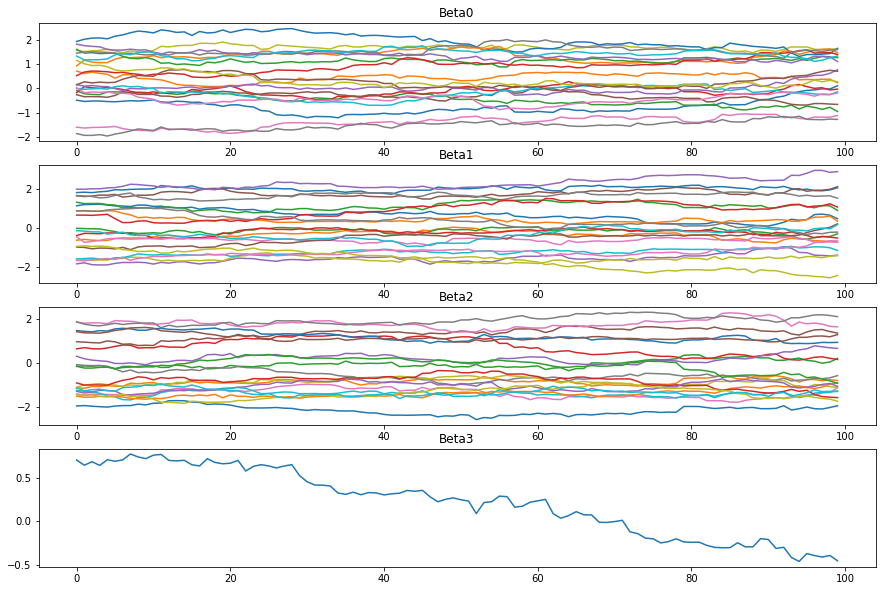

In [181]:
# Trace plot
f, (ax1, ax2, ax3) = plt.subplots(4, 1, figsize=(15,10))
ax1.set_title("Beta0")
ax2.set_title("Beta1")
ax3.set_title("Beta2")
ax4.set_title("Beta3")
ax1.plot(posterior_samples['bayesian_model$$$nn.layer_0.bias'])
ax2.plot(posterior_samples['bayesian_model$$$nn.layer_1.bias'])
ax3.plot(posterior_samples['bayesian_model$$$nn.layer_2.bias'])
f.show()

/home/jorge/miniconda3/envs/ml4ps_pyro/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/jorge/miniconda3/envs/ml4ps_pyro/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


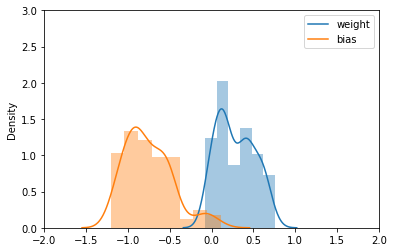

In [112]:
# Plot weights
sns.distplot(posterior_samples["bayesian_model$$$nn.layer_0.weight"][:,0,0])
sns.distplot(posterior_samples["bayesian_model$$$nn.layer_0.bias"][:,0])
plt.legend(["weight", "bias"])
plt.axis([-2,2,0,3])
plt.show()

In [115]:
# Make predictions for test set
predictive = Predictive(nn_model, posterior_samples)
samples = predictive(X_test)

/home/jorge/miniconda3/envs/ml4ps_pyro/lib/python3.8/site-packages/pyro/primitives.py:404: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  warnings.warn("The `random_module` primitive is deprecated, and will be removed "


In [144]:
y_pred = samples["obs"].mean(axis=0).detach().numpy()
mse = np.mean((y_test.numpy() - y_pred)**2)
print("MSE:", mse)

MSE: 0.08251218


In [136]:
idx=0
preds = []
for x in X_u[idx*n_data:idx*n_data+n_data, 0:2]:
    x = torch.Tensor(x)
    preds.append(predictive(x)["obs"])

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

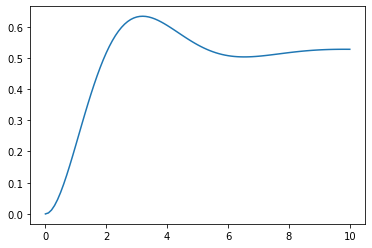

In [166]:
plt.plot(X_u[idx*n_data:idx*n_data+n_data, 1], y_delta[idx*n_data:idx*n_data+n_data], label="exact")
plt.plot(X_u[idx*n_data:idx*n_data+n_data, 1], [t.numpy().mean() for t in preds], label="prediction")
plt.fill_between(X_u[idx*n_data:idx*n_data+n_data, 1], [t.numpy().mean() + t.numpy().std() for t in preds], [t.numpy().mean() - t.numpy().std() for t in preds], label="prediction")
plt.xlabel("Time [s]")
plt.ylabel("δ [rad]")
plt.legend()

## Variational Inference

In [68]:
model = Model()
guide = AutoDiagonalNormal(model)
optimizer = pyro.optim.Adam({"lr": 1e-3})
svi = SVI(model, guide, optimizer, loss=Trace_ELBO(num_particles=1))
n_epochs=20000

pyro.clear_param_store()
#for epoch in tqdm(range(n_epochs), unit='epoch'):
for epoch in range(n_epochs):
    loss = svi.step(X, y)
    if epoch % 500 == 0:
        print("[%d] ELBO: %.1f" % (epoch, loss))

/home/jorge/miniconda3/envs/ml4ps_pyro/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/jorge/miniconda3/envs/ml4ps_pyro/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/jorge/miniconda3/envs/ml4ps_pyro/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")


[0] ELBO: nan


/home/jorge/miniconda3/envs/ml4ps_pyro/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/jorge/miniconda3/envs/ml4ps_pyro/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/jorge/miniconda3/envs/ml4ps_pyro/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/jorge/miniconda3/envs/ml4ps_pyro/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/jorge/miniconda3/envs/ml4ps_pyro/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/jorge/miniconda3/envs/ml4ps_pyro/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/jorge/miniconda3/envs/ml4ps_pyro/l

KeyboardInterrupt: 

In [206]:
# Make predictions for test set
predictive = Predictive(model, guide=guide, num_samples=1000,
                        return_sites=("obs", "_RETURN"))
samples = predictive(X_test)

y_pred = samples["obs"].mean(axis=0).detach().numpy()
mse = np.mean((y_test.numpy() - y_pred)**2)
print("MSE:", mse)

Warmup:   0%|          | 51/20000 [08:59, 10.59s/it, step size=1.71e-05, acc. prob=0.787]


MSE: 0.17665848


In [210]:
idx=0
preds = predictive(torch.Tensor(X_u[idx*n_data:idx*n_data+n_data, 0:2]))["obs"]
preds_mean = np.array([t.detach().numpy().mean() for t in preds.T])
preds_std = np.array([t.detach().numpy().std() for t in preds.T])

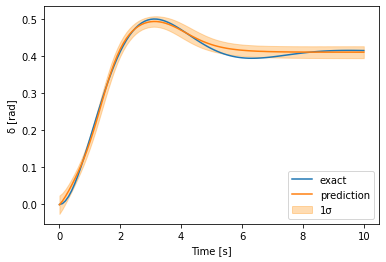

In [211]:
plt.plot(X_u[idx*n_data:idx*n_data+n_data, 1], y_delta[idx*n_data:idx*n_data+n_data], label="exact")
plt.plot(X_u[idx*n_data:idx*n_data+n_data, 1], preds_mean, label="prediction")
plt.fill_between(X_u[idx*n_data:idx*n_data+n_data, 1], preds_mean + preds_std, preds_mean - preds_std,
                 alpha=0.3, color="darkorange", label="1σ")
plt.xlabel("Time [s]")
plt.ylabel("δ [rad]")
plt.legend()

## BPINN

In [ ]:
def gradients(self, outputs, inputs):
        return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True)[0]

class BPINN(PyroModule):
    def __init__(self, h0=2, h1=20, h2=20, sigma=1):
        super().__init__()
        self.fc1 = PyroModule[nn.Linear](h0, h1)
        self.fc1.weight = PyroSample(dist.Normal(0., sigma).expand([h1, h0]).to_event(2))
        self.fc1.bias = PyroSample(dist.Normal(0., sigma).expand([h1]).to_event(1))
        self.fc2 = PyroModule[nn.Linear](h1, h2)
        self.fc2.weight = PyroSample(dist.Normal(0., sigma).expand([h2, h1]).to_event(2))
        self.fc2.bias = PyroSample(dist.Normal(0., sigma).expand([h2]).to_event(1))
        self.fc3 = PyroModule[nn.Linear](h2, 1)
        self.fc3.weight = PyroSample(dist.Normal(0., sigma).expand([1, h2]).to_event(2))
        self.fc3.bias = PyroSample(dist.Normal(0., sigma).expand([1]).to_event(1))
        self.act = nn.Tanh()

    def forward(self, x, y=None):
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        mu = self.fc3(x).squeeze()
        
        # First derivative
        dudx = gradients(u, x)
        dudt = dudx[:, 1]
        
        # Second derivative
        dudxx = gradients(dudx, x)
        dudtt = dudxx[:, 1]

        # Physics term
        f = m * dudtt + d * dudt + B * torch.sin(u) - X[:, 0]
        
        sigma = 0.001
        with pyro.plate("data", x.shape[0]):
            y = pyro.sample("obs", dist.Normal(mu, sigma), obs=y)
        return y
    
    # The generative process
    with pyro.plate("observations"):
        
        X.requires_grad_(True)
        
        # Forward pass
        u = sampled_model(X).squeeze(-1) # Feed-forward the design matrix X through the neural network  
        
        y = pyro.sample("obs", dist.Normal(f, 0.01), obs=y)
        
    return y

Single trajectory
Pseudocode BNN vs BPINN
Update step MCMC vs VI
New way of BNN
Normalization (input and batch?)